# Predicting cases in a different region

Predicting reported cases in a region from all other regions.

## Loading packages and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import os
import warnings
import statsmodels.api as sm
import itertools

from src.figures_style import initialise_figures, get_categorical_palette
initialise_figures()

from src.sigproc import moving_avg, shift, filter

from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

from src.lstm_network import LSTM_network
from captum.attr import IntegratedGradients

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

2023-08-04 09:31:17.386493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Survey data

In [2]:
# Data file not included in the repository on privacy grounds

DATA_PARQUET_PATH = 'hope_data/EWS_0326_klar.parquet'
df = pd.read_parquet(DATA_PARQUET_PATH)

# Time series data

df['Day'] = df['Timings_dateFinish'] # We use the date when the survey is submitted as a basis
df['Week'] = df['Day'].dt.to_period('W').dt.start_time
df['Month'] = df['Day'].dt.to_period('M').dt.start_time
df['Year'] = df['Day'].dt.to_period('Y').dt.start_time

df = df[(df['Day'] >= '2020-07-01') & (df['Day'] < '2022-01-01')]

# Crafting features

df['N_Contacts'] = df['Q4a_1'] + df['Q4a_2'] + df['Q4a_3'] + df['Q4a_4']
df['Individual_Behaviour'] = df[[f'Q3_{i}' for i in range(1, 8)]].astype('double').mean(axis=1)
df['Q5_3_inv'] = df['Q5_3'].max() + 1 - df['Q5_3']
df['Others_Behaviour'] = (df['Q5_1'] + df['Q5_2'] + df['Q5_3_inv'] + df['Q6_3']).astype('double')/4
df['Randoms_Behaviour'] = (df['Q5_2'] + df['Q5_3_inv']).astype('double')/2
df['Authorities_Trust'] = (df['Q2_3'] + df['Q2_4'] + df['Q6_2'] + df['Q6_8'] + df['Q6_9']).astype('double')/5
df['Life_Degraded'] = (df['Q2_5'] + df['Q2_6'] + df['Q6_7']).astype('double')/3

# NMF features

from sklearn.decomposition import NMF

FEATURES = ['Q1_1', 'Q1_2'] + \
           [f'Q2_{i}' for i in range(1, 7)] + \
           [f'Q3_{i}' for i in range(1, 8)] + \
           [f'Q4a_{i}' for i in range(1, 5)] + \
           [f'Q5_{i}' for i in range(1, 6)] + \
           [f'Q6_{i}' for i in range(1, 10)] + \
           [f'Q7_{i}' for i in range(1, 6)]
    
df_red = df[FEATURES + ['Week']].dropna(axis=0).copy()
for f in FEATURES:
    df_red[f] = df_red[f].rank(pct=True)

nmf = NMF(5, max_iter=1024, alpha_W=2e-3, alpha_H=1e-1)
W = nmf.fit_transform(df_red.drop('Week', axis=1))
H = nmf.components_

NMF_ARCHETYPES = [
    "'Measures against COVID make my life harder'",
    "'I trust authorities are doing what is necessary and do it well'",
    "'I follow health recommendations seriously'",
    "'I have had a lot of contacts because other are not being serious enough, also I have symptoms'",
    "'Others are being serious and doing their part'"
]

df_red[NMF_ARCHETYPES] = W
df[NMF_ARCHETYPES] = df_red[NMF_ARCHETYPES]

del df_red

# Risk-taking behaviour

RISKY_THR = 0.70
N_RISKY_CONTACTS = np.quantile(df[(df['Day'] >= '2020-08-01') & (df['Day'] < '2020-09-01')]['N_Contacts'], RISKY_THR)
df['Risky_Contacts'] = df['N_Contacts'] > N_RISKY_CONTACTS

df.head()

,udsendt,Timings_dateFirstEntry,Timings_dateLastEntry,Timings_dateFinish,Timings_timeTotalMinutes,koen,aldernum,aldercat,postnr,kommune,kommune_aktuel,region,Q1_1,Q1_2,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q3_1,Q3_2,Q3_3,Q3_4,Q3_5,Q3_6,Q3_7,Q4a_1,Q4a_2,Q4a_3,Q4a_4,Q4b_1,Q4b_2,Q4b_3,Q4b_4,Q5_1,Q5_2,Q5_3,Q5_4,Q5_5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Ny1,Q2020NovNy1,Q2020NovNy2,Q2020NovNy3,Q2020NovNy4,Q2021FebNy1,Q2021DecNy1,Q2021DecNy2,Q10,Q11,Q12,Q14,Q15,Q16,DagVej,UgeVej,weight,antal_påbegyndt,antal_vaccinerede,population,Day,Week,Month,Year,N_Contacts,Individual_Behaviour,Q5_3_inv,Others_Behaviour,Randoms_Behaviour,Authorities_Trust,Life_Degraded,'Measures against COVID make my life harder','I trust authorities are doing what is necessary and do it well','I follow health recommendations seriously',"'I have had a lot of contacts because other are not being serious enough, also I have symptoms'",'Others are being serious and doing their part',Risky_Contacts
orgpid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
172AS766,2020-06-30,2020-06-30,2020-06-30,2020-07-01,22,Mand,23,18-29 år,2800.0,159 Gladsaxe,159 Gladsaxe,Hovedstaden,5,2,6,7,7,7,2,1,4,3,5,2,3,1,3,0,0,0,0,<NA>,<NA>,<NA>,<NA>,5,6,2,7,1,1,7,5,4,7,7,1,6,6,False,False,False,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,Bachelor (fx 1. del af en lang videregående ud...,1 person,Jeg har ingen hjemmeboende børn,Under uddannelse,V: Venstre,V: Venstre,1.465850,0.496362,0.578246,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,0,3.000000,6,5.50,6.0,6.6,1.333333,0.104188,1.651726,0.000000,0.165240,1.478884,False
510ZS590,2020-06-26,2020-07-01,2020-07-01,2020-07-01,9,Mand,45,40-49 år,2791.0,185 Tårnby,185 Tårnby,Hovedstaden,4,7,7,7,7,7,2,2,7,7,7,7,7,7,7,0,2,4,0,<NA>,2,0,<NA>,6,7,2,7,4,3,7,5,5,5,5,2,7,7,False,False,False,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,"Erhvervsfaglig uddannelse (fx tømrer, frisør e...",2 personer,2 børn,Lønmodtager i en privat virksomhed,A: Socialdemokratiet,A: Socialdemokratiet,1.099070,2.623457,2.359034,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,6,7.000000,6,6.00,6.5,7.0,2.000000,0.274090,0.991306,1.551195,0.337579,1.864396,False
469AT275,2020-07-01,2020-07-01,2020-07-01,2020-07-01,9,Kvinde,47,40-49 år,8400.0,706 Syddjurs,706 Syddjurs,Midtjylland,3,5,7,7,6,7,5,6,7,7,6,7,6,7,7,3,0,1,10,3,<NA>,0,0,6,6,2,7,5,1,7,6,6,7,7,5,6,6,False,False,False,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,Bachelor (fx 1. del af en lang videregående ud...,4 personer,2 børn,Lønmodtager i en privat virksomhed,V: Venstre,A: Socialdemokratiet,1.038313,0.816161,0.925886,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,14,6.714286,6,6.00,6.0,6.4,5.333333,1.018874,1.197054,1.240837,0.455909,1.507616,True
332BS168,2020-06-14,2020-07-01,2020-07-01,2020-07-01,6,Kvinde,57,50-59 år,2770.0,185 Tårnby,185 Tårnby,Hovedstaden,4,5,7,7,7,7,7,7,6,5,6,6,4,5,5,0,3,0,10,<NA>,0,<NA>,5,5,6,3,5,6,3,4,4,3,4,4,5,4,3,False,False,True,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,Korte videregående (fx laborant eller datamati...,1 person,Jeg har ingen hjemmeboende børn,Lønmodtager i en privat virksomhed,A: Socialdemokratiet,I tvivl om partivalg,0.940539,0.280390,0.394033,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,13,5.285714,5,5.00,5.5,5.0,6.333333,1.495463,0.787470,0.586652,1.217815,0.429461,True
190CT408,2020-07-01,2020-07-01,2020-07-01,2020-07-01,7,Kvinde,55,50-59 år,5000.0,461 Odense,461 Odense,Syddanmark,7,7,7,7,7,7,1,1,7,6,7,6,7,7,6,1,2,0,0,0,1,<NA>,<NA>,5,5,4,5,6,1,7,5,6,7,7,1,6,7,False,False,False,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,Mellemlang videregående (fx teknikum ingeniør ...,3 personer,1 barn,"Lønmodtager i det offentlige (stat, kommune el...",A: Socialdemokratiet,A: Socialdemokratiet,0.918438,0.251420,0.335737,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,3,6.571429,4,4.75,4.5,6.8,1.000000,0.000000,1.792597,1.547355,0.220435,1.135128,False


### Epidemiologic data

In [3]:
epidata = pd.read_csv('hope_data/epidata.csv', index_col=0)
epidata['date'] = pd.to_datetime(epidata['date'])
REGIONS = epidata.groupby('region').size().index.tolist()
epidata.head()

,date,region,cases,hospit,deaths,population,cases_smoothed,hospit_smoothed,deaths_smoothed,cases_per_100000,hospit_per_100000,deaths_per_100000,cases_incidence,hospit_incidence,deaths_incidence,cumulative_cases,cumulative_hospit,cumulative_deaths,vaccine_first_dose,vaccine_second_dose,proportion_first_dose,proportion_second_dose
0,2020-02-26,Hovedstaden,0,0,0,1855084,0.250000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,2020-02-27,Hovedstaden,1,0,0,1855084,0.400000,0.200000,0.0,0.053906,0.000000,0.0,0.188671,0.000000,0.0,1.0,0.0,0.0,0,0,0.0,0.0
2,2020-02-28,Hovedstaden,0,0,0,1855084,0.666667,0.166667,0.0,0.000000,0.000000,0.0,0.125780,0.000000,0.0,1.0,0.0,0.0,0,0,0.0,0.0
3,2020-02-29,Hovedstaden,0,0,0,1855084,1.142857,0.285714,0.0,0.000000,0.000000,0.0,0.094335,0.000000,0.0,1.0,0.0,0.0,0,0,0.0,0.0
4,2020-03-01,Hovedstaden,1,1,0,1855084,1.428571,0.285714,0.0,0.053906,0.053906,0.0,0.150937,0.075468,0.0,2.0,1.0,0.0,0,0,0.0,0.0


### Meteorological data

In [4]:
dmi = pd.read_parquet('hope_data/dmi_daily_agg.parquet')
dmi.index = dmi.index.set_levels([pd.to_datetime(dmi.index.levels[0]), dmi.index.levels[1]])
dmi.head()

Average Minimum   Average  Average maximum
Observed   Property                                                 
2020-01-01 Precipitation              NaN  0.023404              NaN
           Temperature           2.329091  4.638280         5.841818
           Wind Speed            3.861538  6.878333         9.650000
2020-01-02 Precipitation              NaN  0.090426              NaN
           Temperature           2.789091  3.795035         4.967273

### Merging everything together

In [5]:
FEATURES = [
    'Individual_Behaviour', 
    'Others_Behaviour', 
    'Authorities_Trust', 
    'Life_Degraded', 
    'Risky_Contacts'
]

df_data = df.groupby(['region', 'Day'])[FEATURES].mean()
df_data[['cases_per_100000', 'hospit_per_100000', 'deaths_per_100000', 'proportion_second_dose']] = \
        epidata.groupby(['region', 'date'])[['cases_per_100000', 'hospit_per_100000', 'deaths_per_100000', 'proportion_second_dose']].sum()

df_data = df_data.dropna()

df_data['temperature'] = df_data.reset_index()['Day'].map(
    dmi.loc[(slice(None), 'Temperature'),:].reset_index(1)['Average']
).values

df_data.head()

Individual_Behaviour  Others_Behaviour  Authorities_Trust  Life_Degraded  Risky_Contacts  cases_per_100000  hospit_per_100000  deaths_per_100000  proportion_second_dose  temperature
region      Day                                                                                                                                                                                              
Hovedstaden 2020-07-01              5.500585          4.288835           5.685990       3.872593        0.293103          0.323435           0.053906           0.000000                     0.0    15.891924
            2020-07-02              5.593500          4.402083           5.631250       3.644279        0.262774          0.754683           0.107812           0.000000                     0.0    15.423255
            2020-07-03              5.465625          4.209424           5.570149       3.614439        0.299107          0.592965           0.000000           0.000000                     0.0    14.130059
            2020-07-04              5.371018          4.167949           5.615686       3.764192        0.349138          0.539059           0.000000           0.053906                     0.0    15.409970
            2020-07-05              5.382706          4.241706           5.618565       3.888011        0.337209          0.431247           0.053906           0.000000                     0.0    16.196792

## Running models

### Our time-series model

In [6]:
# Define the Time series model
class TimeSeriesRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=32, model='gru'):
        super().__init__()
        
        if model == 'gru':
            self.ts = nn.GRU(input_size, hidden_size, batch_first=True) 
        elif model == 'lstm':
            self.ts = nn.LSTM(input_size, hidden_size, batch_first=True)
        else:
            return ValueError(f'Model {model} is not valid, must be one of `gru`, `lstm`')
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.ts(x.float())
        return self.fc(out[:, -1, :])
    
    def fit(self, X_train, y_train, lr=1e-3, wd=1e-3, bs=32, epochs=20):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
        
        X_train = torch.from_numpy(X_train).float()
        y_train = torch.from_numpy(y_train).float()
        
        self.train()
        for epoch in range(epochs):
            permutation = torch.randperm(X_train.size()[0])
            for i in range(0, X_train.size()[0], bs):
                indices = permutation[i:i+bs]
                batch_X, batch_y = X_train[indices], y_train[indices]
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
        return self
    
    def predict(self, X_test):
        X_test = torch.from_numpy(X_test).float()
        
        self.eval()
        return self(X_test).detach().numpy()

### Creating regional training/test sets

In [7]:
PAST   = 7
FUTURE = 14
REGIONS_NO_DK = [region for region in REGIONS if region != 'Danmark']
N_TIMES = 10

X = {region: list() for region in REGIONS_NO_DK}
X_no_survey = {region: list() for region in REGIONS_NO_DK}
y = {region: list() for region in REGIONS_NO_DK}
dates = {region: list() for region in REGIONS_NO_DK}

for region in REGIONS_NO_DK:
    df_X = df_data.loc[region].copy()
    df_X = df_X.astype('float')
    
    df_X = df_X[[f'{col}' for col in FEATURES] + ['temperature', 'proportion_second_dose', 'hospit_per_100000', 'deaths_per_100000', 'cases_per_100000']]
    
    for i in range(len(df_X) - PAST - FUTURE):
        X[region].append(df_X.iloc[i:i+PAST])
        X_no_survey[region].append(df_X[['temperature', 'proportion_second_dose', 'hospit_per_100000', 'deaths_per_100000', 'cases_per_100000']].iloc[i:i+PAST])
        y[region].append(df_X.iloc[i+PAST:i+PAST+FUTURE, -1])
        dates[region].append(df_X.index[i+PAST])

In [8]:
res = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS_NO_DK}
med = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS_NO_DK}
std = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS_NO_DK}

### Baseline

In [9]:
results = []

for test_region in tqdm(REGIONS_NO_DK):
    # Run test
    train_regions = [region for region in REGIONS_NO_DK if region != test_region]
    X_train = np.vstack([v for k, v in X.items() if k in train_regions])
    y_train = np.vstack([v for k, v in y.items() if k in train_regions])
    X_test = np.array(X[test_region])
    y_test = np.array(y[test_region])
    
    results.append([
        np.sqrt(
            mean_squared_error(
                y_test[:,t], 
                X_test[:,-1:,-1]
            )
        )
    for t in range(FUTURE)])
    
    res[test_region].loc['Baseline'] = np.array(results).mean(axis=0)
    std[test_region].loc['Baseline'] = np.array(results).std(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

### Model w/o survey

In [10]:
model_str = 'lstm'

for test_region in tqdm(REGIONS_NO_DK):
    
    results = []
    
    hyperparams = [
        [10, 20, 50],
        [1e-2, 1e-3, 1e-4],
        [1e-3, 1e-4]
    ]
    
    rmse = {k: list() for k in itertools.product(*hyperparams)}
    for valid_region in REGIONS_NO_DK:
        if valid_region == test_region:
            continue
            
        train_regions = [region for region in REGIONS_NO_DK if ((region != test_region) and (region != valid_region))]
        X_train = np.vstack([v for k, v in X_no_survey.items() if k in train_regions])
        y_train = np.vstack([v for k, v in y.items() if k in train_regions])
        X_valid = np.array(X_no_survey[valid_region])
        y_valid = np.array(y[valid_region])
        
        scale_avg = X_train.mean(axis=(0,1))
        scale_std = X_train.std(axis=(0,1))
        X_train -= scale_avg.reshape((1,1,-1))
        X_train /= scale_std.reshape((1,1,-1))
        X_valid -= scale_avg.reshape((1,1,-1))
        X_valid /= scale_std.reshape((1,1,-1))
        #y_train -= scale_avg[-1]
        #y_train /= scale_std[-1]
        #y_valid -= scale_avg[-1]
        #y_valid /= scale_std[-1]
        
        for k in rmse.keys():
            epochs, lr, wd = k
            
            model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=model_str)\
                                       .fit(X_train, y_train, lr=lr, wd=wd, epochs=epochs)
            y_pred = model.predict(X_valid)
            
            rmse[k].append(np.sqrt(mean_squared_error(y_valid, y_pred)))
            
    best_hyper= None
    best_rmse = None

    for k, v in rmse.items():
        if (best_rmse is None) or (np.mean(v) < best_rmse):
            best_rmse = np.mean(v)
            best_hyper = k


    print(f'Best hyperparameters={best_hyper}')
        
    
    # Run test
    train_regions = [region for region in REGIONS_NO_DK if region != test_region]
    X_train = np.vstack([v for k, v in X_no_survey.items() if k in train_regions])
    y_train = np.vstack([v for k, v in y.items() if k in train_regions])
    X_test = np.array(X_no_survey[test_region])
    y_test = np.array(y[test_region])
        
    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))
    #y_train -= scale_avg[-1]
    #y_train /= scale_std[-1]
    #y_test -= scale_avg[-1]
    #y_test /= scale_std[-1]
    
    epochs, lr, wd = best_hyper
    
    for _ in range(N_TIMES):
        model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=model_str)\
                                   .fit(X_train, y_train, lr=lr, wd=wd, epochs=epochs)
        y_pred = model.predict(X_test)

        results.append([
            np.sqrt(
                mean_squared_error(
                    y_test[:,t], 
                    y_pred[:,t]
                )
            )
        for t in range(FUTURE)])
    
    res[test_region].loc['LSTM w/o survey'] = np.array(results).mean(axis=0)
    std[test_region].loc['LSTM w/o survey'] = np.array(results).std(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

Best hyperparameters=(20, 0.01, 0.0001)
Best hyperparameters=(50, 0.01, 0.0001)
Best hyperparameters=(50, 0.01, 0.001)
Best hyperparameters=(10, 0.01, 0.001)
Best hyperparameters=(20, 0.01, 0.001)


### Model w/ survey

In [11]:
model_str = 'gru'

for test_region in tqdm(REGIONS_NO_DK):
    
    results = []
    
    hyperparams = [
        [10, 20, 50],
        [1e-2, 1e-3, 1e-4],
        [1e-3, 1e-4]
    ]
    
    rmse = {k: list() for k in itertools.product(*hyperparams)}
    for valid_region in REGIONS_NO_DK:
        if valid_region == test_region:
            continue
            
        train_regions = [region for region in REGIONS_NO_DK if ((region != test_region) and (region != valid_region))]
        X_train = np.vstack([v for k, v in X.items() if k in train_regions])
        y_train = np.vstack([v for k, v in y.items() if k in train_regions])
        X_valid = np.array(X[valid_region])
        y_valid = np.array(y[valid_region])
        
        scale_avg = X_train.mean(axis=(0,1))
        scale_std = X_train.std(axis=(0,1))
        X_train -= scale_avg.reshape((1,1,-1))
        X_train /= scale_std.reshape((1,1,-1))
        X_valid -= scale_avg.reshape((1,1,-1))
        X_valid /= scale_std.reshape((1,1,-1))
        #y_train -= scale_avg[-1]
        #y_train /= scale_std[-1]
        #y_valid -= scale_avg[-1]
        #y_valid /= scale_std[-1]
        
        for k in rmse.keys():
            epochs, lr, wd = k
            
            model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=model_str)\
                                       .fit(X_train, y_train, lr=lr, wd=wd, epochs=epochs)
            y_pred = model.predict(X_valid)
            
            rmse[k].append(np.sqrt(mean_squared_error(y_valid, y_pred)))
            
    best_hyper= None
    best_rmse = None

    for k, v in rmse.items():
        if (best_rmse is None) or (np.mean(v) < best_rmse):
            best_rmse = np.mean(v)
            best_hyper = k


    print(f'Best hyperparameters={best_hyper}')
        
    
    # Run test
    train_regions = [region for region in REGIONS_NO_DK if region != test_region]
    X_train = np.vstack([v for k, v in X.items() if k in train_regions])
    y_train = np.vstack([v for k, v in y.items() if k in train_regions])
    X_test = np.array(X[test_region])
    y_test = np.array(y[test_region])
        
    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))
    #y_train -= scale_avg[-1]
    #y_train /= scale_std[-1]
    #y_test -= scale_avg[-1]
    #y_test /= scale_std[-1]
    
    epochs, lr, wd = best_hyper
    
    for _ in range(N_TIMES):
        model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=model_str)\
                                   .fit(X_train, y_train, lr=lr, wd=wd, epochs=epochs)
        y_pred = model.predict(X_test)

        results.append([
            np.sqrt(
                mean_squared_error(
                    y_test[:,t], 
                    y_pred[:,t]
                )
            )
        for t in range(FUTURE)])
    
    res[test_region].loc['GRU'] = np.array(results).mean(axis=0)
    std[test_region].loc['GRU'] = np.array(results).std(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

Best hyperparameters=(50, 0.01, 0.001)
Best hyperparameters=(50, 0.01, 0.0001)
Best hyperparameters=(50, 0.01, 0.001)
Best hyperparameters=(50, 0.01, 0.0001)
Best hyperparameters=(50, 0.01, 0.0001)


### LSTM

In [12]:
model_str = 'lstm'

for test_region in tqdm(REGIONS_NO_DK):
    
    results = []
    
    hyperparams = [
        [10, 20, 50],
        [1e-2, 1e-3, 1e-4],
        [1e-3, 1e-4]
    ]
    
    rmse = {k: list() for k in itertools.product(*hyperparams)}
    for valid_region in REGIONS_NO_DK:
        if valid_region == test_region:
            continue
            
        train_regions = [region for region in REGIONS_NO_DK if ((region != test_region) and (region != valid_region))]
        X_train = np.vstack([v for k, v in X.items() if k in train_regions])
        y_train = np.vstack([v for k, v in y.items() if k in train_regions])
        X_valid = np.array(X[valid_region])
        y_valid = np.array(y[valid_region])
        
        scale_avg = X_train.mean(axis=(0,1))
        scale_std = X_train.std(axis=(0,1))
        X_train -= scale_avg.reshape((1,1,-1))
        X_train /= scale_std.reshape((1,1,-1))
        X_valid -= scale_avg.reshape((1,1,-1))
        X_valid /= scale_std.reshape((1,1,-1))
        #y_train -= scale_avg[-1]
        #y_train /= scale_std[-1]
        #y_valid -= scale_avg[-1]
        #y_valid /= scale_std[-1]
        
        for k in rmse.keys():
            epochs, lr, wd = k
            
            model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=model_str)\
                                       .fit(X_train, y_train, lr=lr, wd=wd, epochs=epochs)
            y_pred = model.predict(X_valid)
            
            rmse[k].append(np.sqrt(mean_squared_error(y_valid, y_pred)))
            
    best_hyper= None
    best_rmse = None

    for k, v in rmse.items():
        if (best_rmse is None) or (np.mean(v) < best_rmse):
            best_rmse = np.mean(v)
            best_hyper = k


    print(f'Best hyperparameters={best_hyper}')
        
    
    # Run test
    train_regions = [region for region in REGIONS_NO_DK if region != test_region]
    X_train = np.vstack([v for k, v in X.items() if k in train_regions])
    y_train = np.vstack([v for k, v in y.items() if k in train_regions])
    X_test = np.array(X[test_region])
    y_test = np.array(y[test_region])
        
    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))
    #y_train -= scale_avg[-1]
    #y_train /= scale_std[-1]
    #y_test -= scale_avg[-1]
    #y_test /= scale_std[-1]
    
    epochs, lr, wd = best_hyper
    
    for _ in range(N_TIMES):
        model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=model_str)\
                                   .fit(X_train, y_train, lr=lr, wd=wd, epochs=epochs)
        y_pred = model.predict(X_test)

        results.append([
            np.sqrt(
                mean_squared_error(
                    y_test[:,t], 
                    y_pred[:,t]
                )
            )
        for t in range(FUTURE)])
    
    res[test_region].loc['LSTM'] = np.array(results).mean(axis=0)
    std[test_region].loc['LSTM'] = np.array(results).std(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

Best hyperparameters=(20, 0.01, 0.0001)
Best hyperparameters=(20, 0.01, 0.0001)
Best hyperparameters=(50, 0.01, 0.0001)
Best hyperparameters=(20, 0.01, 0.0001)
Best hyperparameters=(20, 0.01, 0.0001)


## Results

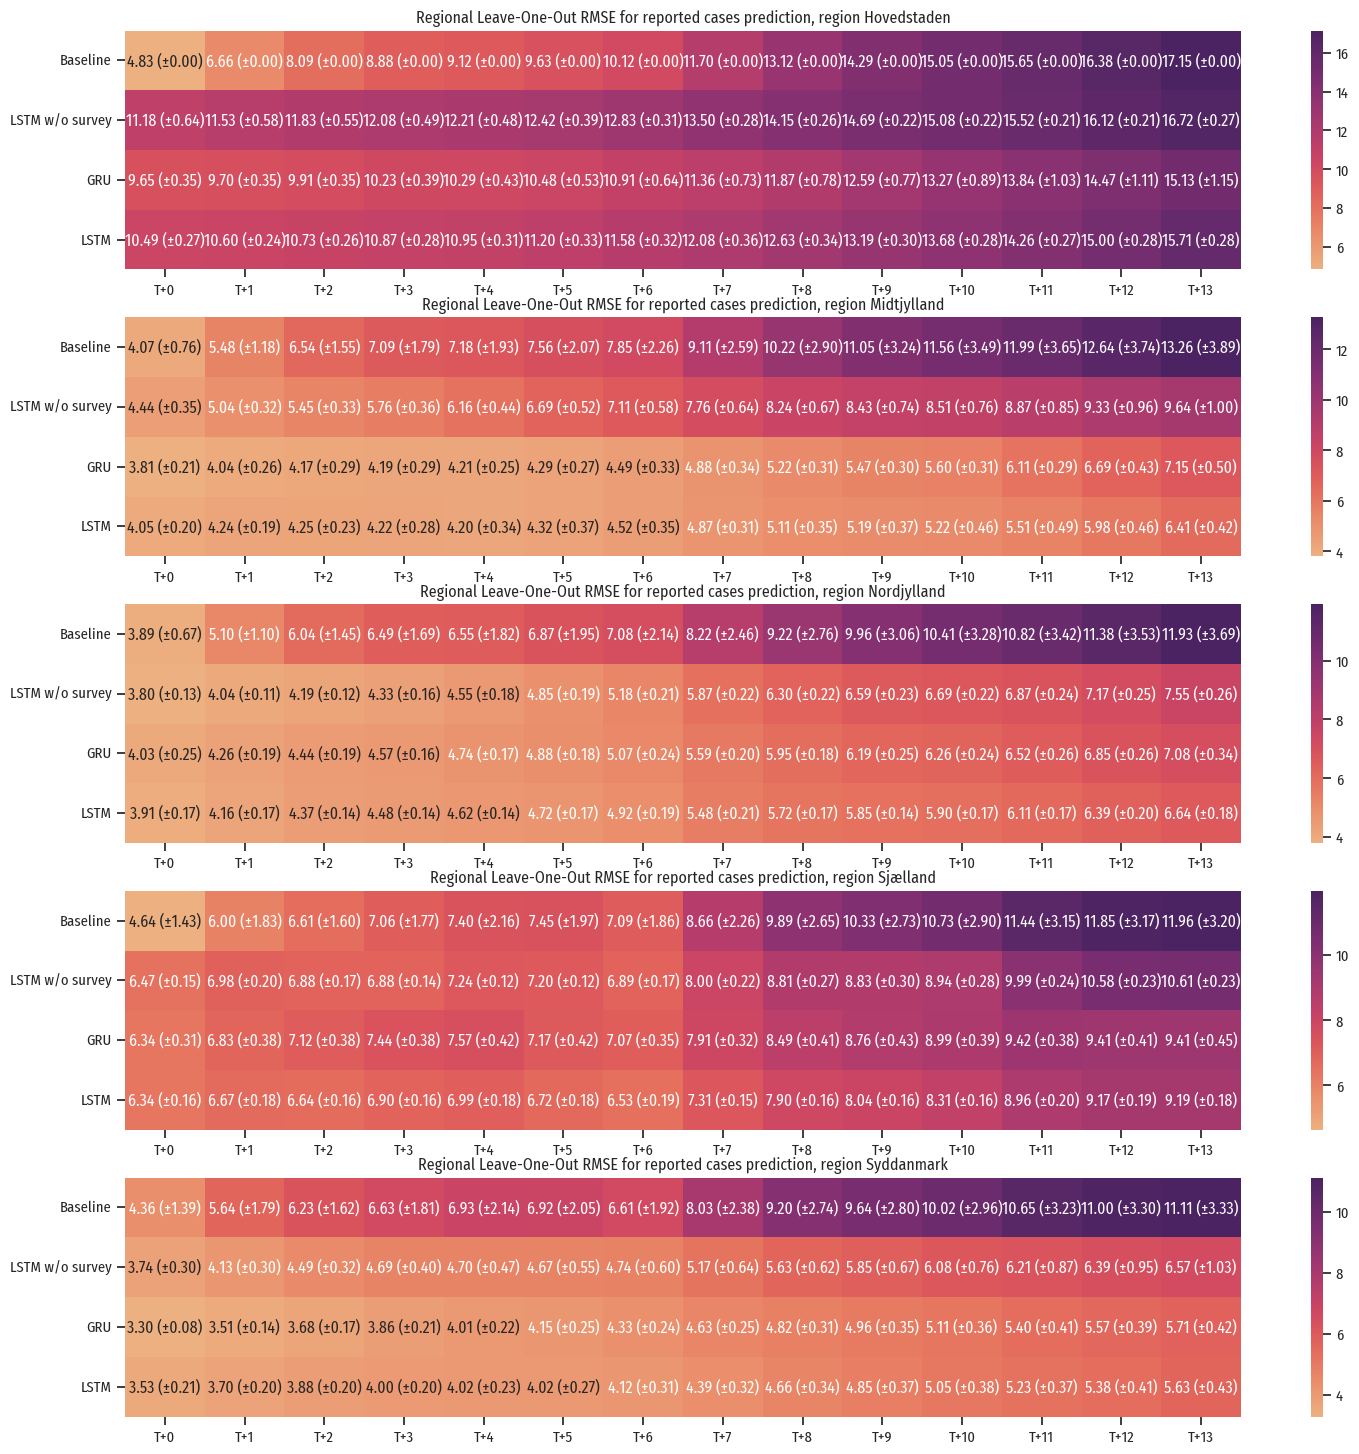

In [13]:
def get_str(avg, std):
    out = list()
    
    for i in range(avg.shape[0]):
        out.append(list())
        for j in range(avg.shape[1]):
            out[-1].append(f'{avg.iloc[i, j]:.2f} (±{std.iloc[i, j]:.2f})')
            
    return out



_, axs = plt.subplots(5, 1, figsize=(18,18))

for r, region in enumerate(REGIONS_NO_DK):
    annots = get_str(res[region], std[region])
    sns.heatmap(res[region], annot=annots, fmt='', cmap='flare', ax=axs[r]).set(title=f'Regional Leave-One-Out RMSE for reported cases prediction, region {region}')

plt.savefig('figures/models_loo_cases_all.png', bbox_inches='tight', pad_inches=0., dpi=1200)
plt.show()

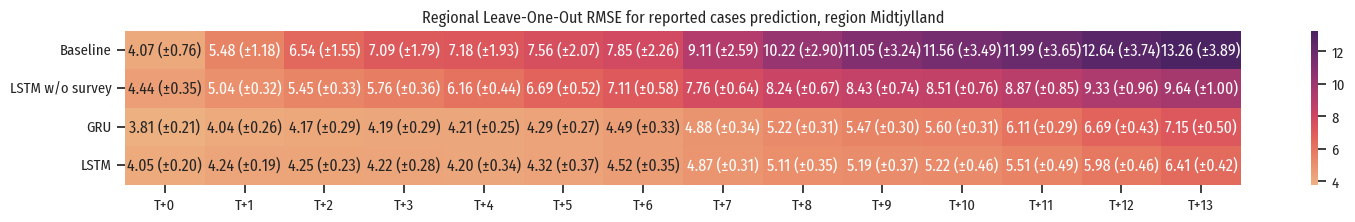

In [14]:
_, ax = plt.subplots(figsize=(18,2))

annots = get_str(res['Midtjylland'], std['Midtjylland'])
sns.heatmap(res['Midtjylland'], annot=annots, fmt='', cmap='flare', ax=ax).set(title=f'Regional Leave-One-Out RMSE for reported cases prediction, region Midtjylland')

plt.savefig('figures/models_loo_cases_midtjylland.png', bbox_inches='tight', pad_inches=0., dpi=1200)
plt.show()

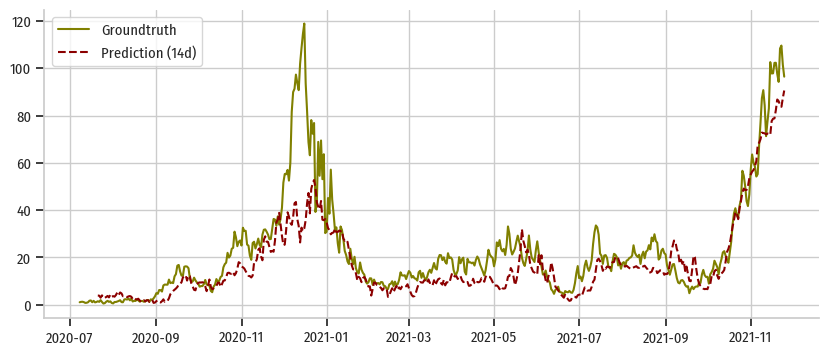

In [24]:
test_region = 'Hovedstaden'

train_regions = [region for region in REGIONS_NO_DK if region != test_region]
X_train = np.vstack([v for k, v in X.items() if k in train_regions])
y_train = np.vstack([v for k, v in y.items() if k in train_regions])
X_test = np.array(X[test_region])
y_test = np.array(y[test_region])

scale_avg = X_train.mean(axis=(0,1))
scale_std = X_train.std(axis=(0,1))
X_train -= scale_avg.reshape((1,1,-1))
X_train /= scale_std.reshape((1,1,-1))
X_test -= scale_avg.reshape((1,1,-1))
X_test /= scale_std.reshape((1,1,-1))

model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=model_str)\
                            .fit(X_train, y_train, lr=1e-2, wd=1e-4, epochs=50)
y_pred = model.predict(X_test)

y_pred_h = y_pred
y_test_h = y_test

_, ax = plt.subplots(figsize=(10,4))

sns.lineplot(x=dates[test_region], y=y_test[:,0].flatten(), color='olive', label='Groundtruth', ax=ax)
#sns.lineplot(x=dates[test_region], y=y_pred[:,0].flatten(), color='indianred', label='Prediction (1d)', ls='--')
sns.lineplot(x=dates[test_region][13:], y=y_pred[:-13,13].flatten(), color='darkred', label='Prediction (14d)', ls='--', ax=ax)

plt.savefig('figures/lstm_loo_it_capital.png', bbox_inches='tight', pad_inches=0., dpi=1200)
plt.show()

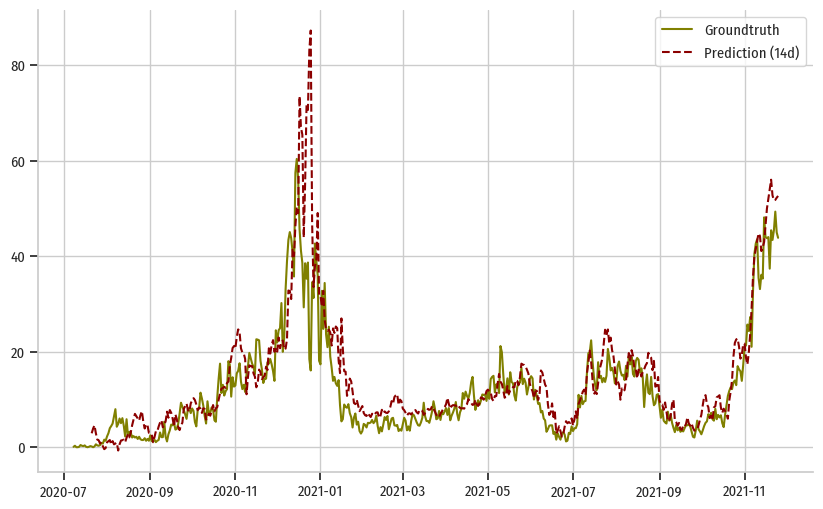

In [25]:
test_region = 'Midtjylland'

train_regions = [region for region in REGIONS_NO_DK if region != test_region]
X_train = np.vstack([v for k, v in X.items() if k in train_regions])
y_train = np.vstack([v for k, v in y.items() if k in train_regions])
X_test = np.array(X[test_region])
y_test = np.array(y[test_region])

scale_avg = X_train.mean(axis=(0,1))
scale_std = X_train.std(axis=(0,1))
X_train -= scale_avg.reshape((1,1,-1))
X_train /= scale_std.reshape((1,1,-1))
X_test -= scale_avg.reshape((1,1,-1))
X_test /= scale_std.reshape((1,1,-1))

model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=model_str)\
                            .fit(X_train, y_train, lr=1e-2, wd=1e-4, epochs=50)
y_pred = model.predict(X_test)

y_pred_m = y_pred
y_test_m = y_test

_, ax = plt.subplots(figsize=(10,6))

sns.lineplot(x=dates[test_region], y=y_test[:,0].flatten(), color='olive', label='Groundtruth')
#sns.lineplot(x=dates[test_region], y=y_pred[:,0].flatten(), color='indianred', label='Prediction (1d)', ls='--')
sns.lineplot(x=dates[test_region][13:], y=y_pred[:-13,13].flatten(), color='darkred', label='Prediction (14d)', ls='--')

plt.savefig('figures/lstm_loo_it_midtjylland.png', bbox_inches='tight', pad_inches=0., dpi=1200)
plt.show()

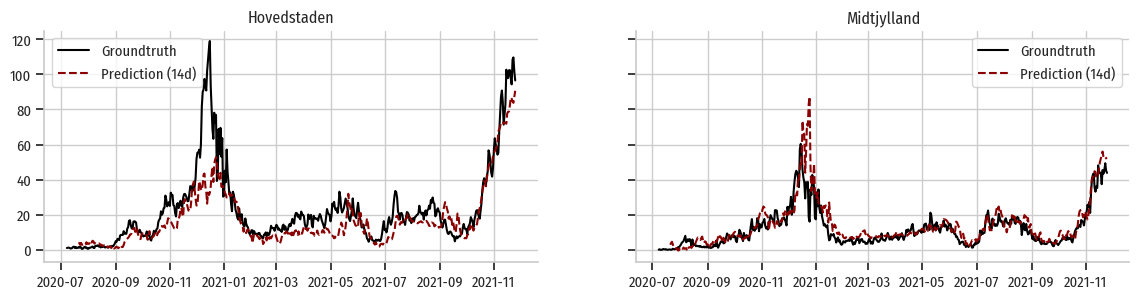

In [37]:
_, axs = plt.subplots(1, 2, figsize=(14,3), sharey=True)

sns.lineplot(x=dates[test_region], y=y_test_h[:,0].flatten(), color='black', label='Groundtruth', ax=axs[0])
sns.lineplot(x=dates[test_region][13:], y=y_pred_h[:-13,13].flatten(), color='darkred', label='Prediction (14d)', ls='--', ax=axs[0])
axs[0].set(title='Hovedstaden')

sns.lineplot(x=dates[test_region], y=y_test_m[:,0].flatten(), color='black', label='Groundtruth', ax=axs[1])
sns.lineplot(x=dates[test_region][13:], y=y_pred_m[:-13,13].flatten(), color='darkred', label='Prediction (14d)', ls='--', ax=axs[1])
axs[1].set(title='Midtjylland')

plt.savefig('figures/lstm_loo_compare.png', bbox_inches='tight', pad_inches=0., dpi=1200)
plt.show()

## Explaining LSTM predictions

In [19]:
EPOCHS = 50
LR = 1e-2
WD = 1e-4
HIDDEN_SIZE = 32
MODEL = 'lstm'
test_region = 'Midtjylland'
eps = 1e-3
bias_factor = 0.

preds = pd.DataFrame(columns=['Date', 'Predicted R(t)'])

train_regions = [region for region in REGIONS_NO_DK if region != test_region]
X_train = np.vstack([v for k, v in X.items() if k in train_regions])
y_train = np.vstack([v for k, v in y.items() if k in train_regions])
X_test = np.array(X[test_region])
y_test = np.array(y[test_region])

scale_avg = X_train.mean(axis=(0,1))
scale_std = X_train.std(axis=(0,1))
X_train -= scale_avg.reshape((1,1,-1))
X_train /= scale_std.reshape((1,1,-1))
X_test -= scale_avg.reshape((1,1,-1))
X_test /= scale_std.reshape((1,1,-1))

N_TIMES = 200
explanations = list()
integrated_gradients = list()

for i in trange(N_TIMES):
    model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, hidden_size=HIDDEN_SIZE, model=MODEL)\
                               .fit(X_train, y_train, lr=LR, wd=WD, epochs=EPOCHS)

    y_pred = model.predict(X_test)
    
    for j in range(y_pred.shape[0]):
        preds.loc[len(preds)] = (dates[test_region][j], y_pred[j][0])
        
    W = [p for p in model.parameters()]
    
    W_t = list()
    W_t.append(W[0].T.detach().numpy())
    W_t.append(W[1].T.detach().numpy())
    W_t.append((W[2] + W[3]).detach().numpy())
    W_t.append(np.zeros_like(W_t[0]))
    W_t.append(np.zeros_like(W_t[1]))
    W_t.append(np.zeros_like(W_t[2]))
    W_t.append(
        np.vstack((
            W[4].T.detach().numpy(),
            np.zeros_like(W[4].T.detach().numpy())
        ))
    )
    W_t.append(W[5].detach().numpy() )

    lstm_expl = LSTM_network(HIDDEN_SIZE, X_train.shape[2], FUTURE, W_t)
    lstm_expl, _ = lstm_expl.lrp(np.array(X[test_region]), y=np.ones(len(X[test_region])) * (FUTURE-1), eps=eps, bias_factor=bias_factor)
    lstm_expl = lstm_expl.numpy().mean(axis=0).T
    lstm_expl /= np.max(np.abs(lstm_expl))
    explanations.append(lstm_expl)
    
    ig = IntegratedGradients(model)
    lstm_ig = ig.attribute(torch.from_numpy(np.array(X[test_region])), target=torch.from_numpy(np.ones(len(X[test_region]), dtype=np.int64) * (FUTURE-1)), n_steps=200)
    lstm_ig = lstm_ig.numpy().mean(axis=0).T
    lstm_ig /= np.max(np.abs(lstm_ig))
    integrated_gradients.append(lstm_ig)
    
explanations = np.array(explanations)

  0%|          | 0/200 [00:00<?, ?it/s]

Explanation using LRP:


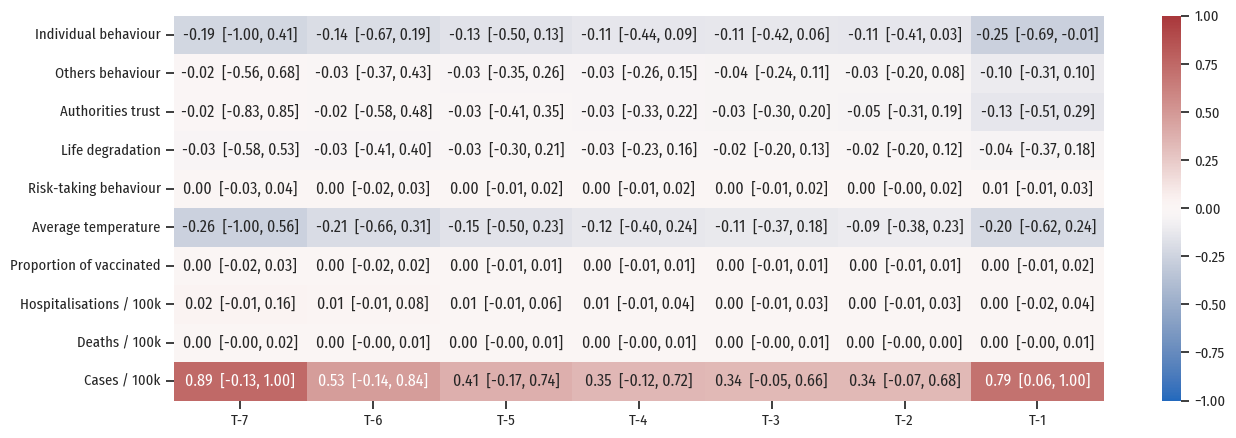

In [35]:
def get_str(x):
    avg = x.mean(axis=0)
    std = x.std(axis=0)
    
    med = np.median(x, axis=0)
    q2_5 = np.quantile(x, q=0.025, axis=0)
    q97_5 = np.quantile(x, q=0.975, axis=0)
    
    out = list()
    
    for i in range(x.shape[1]):
        out.append(list())
        for j in range(x.shape[2]):
            #out[-1].append(f'{avg[i][j]:.2f} (±{std[i][j]:.2f})')
            out[-1].append(f'{med[i][j]:.2f}  [{q2_5[i][j]:.2f}, {q97_5[i][j]:.2f}]')
            
    return out

annots = get_str(explanations)
YLABELS = [
    'Individual behaviour',
    'Others behaviour',
    'Authorities trust',
    'Life degradation',
    'Risk-taking behaviour',
    'Average temperature',
    'Proportion of vaccinated',
    'Hospitalisations / 100k',
    'Deaths / 100k',
    'Cases / 100k'
]

print('Explanation using LRP:')

_, ax = plt.subplots(figsize=(15,5))

sns.heatmap(explanations.mean(axis=0), vmin=-1, vmax=1, 
            annot=annots, fmt='', cmap='vlag', ax=ax,
            xticklabels=[f'T{i}' for i in range(-explanations.shape[2], 0)],
            yticklabels=YLABELS)

plt.savefig('figures/lrp_loo_cases.png', bbox_inches='tight', pad_inches=0., dpi=1200)
plt.show()

Explanation using IG:


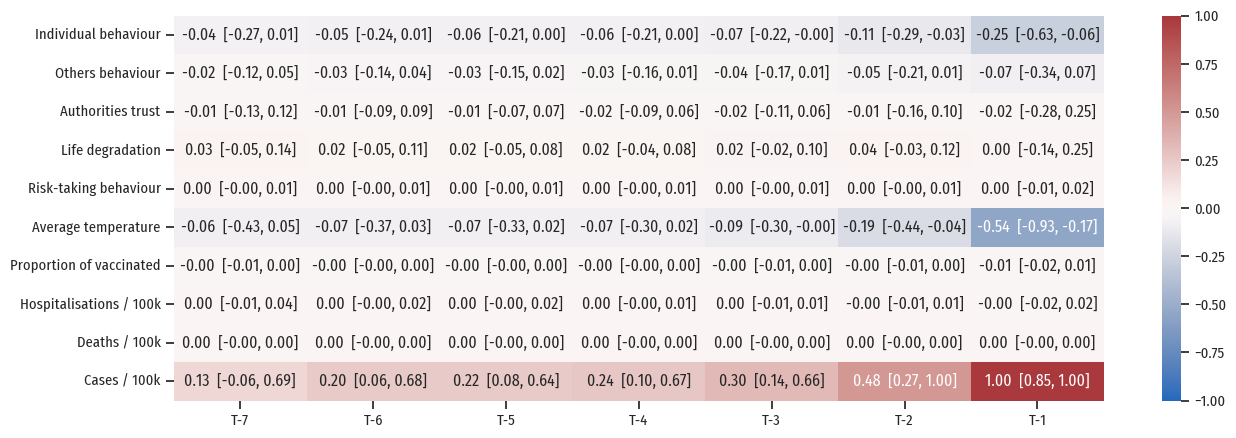

In [36]:
def get_str(x):
    avg = x.mean(axis=0)
    std = x.std(axis=0)
    
    med = np.median(x, axis=0)
    q2_5 = np.quantile(x, q=0.025, axis=0)
    q97_5 = np.quantile(x, q=0.975, axis=0)
    
    out = list()
    
    for i in range(x.shape[1]):
        out.append(list())
        for j in range(x.shape[2]):
            #out[-1].append(f'{avg[i][j]:.2f} (±{std[i][j]:.2f})')
            out[-1].append(f'{med[i][j]:.2f}  [{q2_5[i][j]:.2f}, {q97_5[i][j]:.2f}]')
            
    return out

integrated_gradients = np.array(integrated_gradients)
annots = get_str(integrated_gradients)
YLABELS = [
    'Individual behaviour',
    'Others behaviour',
    'Authorities trust',
    'Life degradation',
    'Risk-taking behaviour',
    'Average temperature',
    'Proportion of vaccinated',
    'Hospitalisations / 100k',
    'Deaths / 100k',
    'Cases / 100k'
]

print('Explanation using IG:')

_, ax = plt.subplots(figsize=(15,5))

sns.heatmap(integrated_gradients.mean(axis=0), vmin=-1, vmax=1, 
            annot=annots, fmt='', cmap='vlag', ax=ax,
            xticklabels=[f'T{i}' for i in range(-integrated_gradients.shape[2], 0)],
            yticklabels=YLABELS)

plt.savefig('figures/ig_loo_cases.png', bbox_inches='tight', pad_inches=0., dpi=1200)
plt.show()